# Naive Bayes Classifier

As the name of Naive Bayes Classifier, this method is based on Bayes' theroem.
#### **Bayes' theroem**
$$P(Class|X) = \frac{p(X|Class)P(Class)}{P(X)}$$

where $P(Class|X)$ is posterior probability, $p(X|Class)$ is likelihood, $P(Class)$ is class prior probability and $P(X)$ is data prior probability. From this formula, we can tell that Bayes's theroem is the inference posterior probability from likelihood and posterior probability.

Here we use iris data as example.

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

# load iris dataset
iris = datasets.load_iris()
iris_df=pd.DataFrame(iris.data)
iris_df['class']=iris.target
iris_df.columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_df['species'] = [iris['target_names'][x] for x in iris_df['class']]
iris_df.dropna(how="all", inplace=True)

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

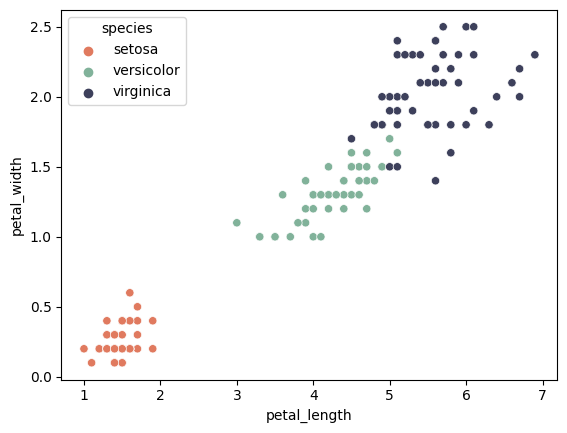

In [2]:
import seaborn as sns

# visualize data
colormaps = np.array(['#e07a5f','#3d405b','#81b29a'])
sns.scatterplot(
    x='petal_length', 
    y='petal_width',
    hue='species',
    data=iris_df,
    palette=dict(setosa="#e07a5f", virginica="#3d405b", versicolor="#81b29a")
    )

Calculate the mean, covariance of each feature of each species and the class prior probabilities.

In [3]:
X = iris.data
y = iris.target

n_samples, n_features = X.shape
n_classes = len(np.unique(y))

mean_cf = np.zeros((n_classes, n_features))
variance_cf = np.zeros((n_classes, n_features))
prior_c = np.zeros(n_classes)

for c in range(n_classes):
    X_c = X[y==c]

    mean_cf[c] = X_c.mean(axis=0)
    variance_cf[c] = X_c.var(axis=0)
    prior_c[c] = X_c.shape[0] / n_samples

In [4]:
print('mean of each feature of each class:\n ',mean_cf)
print('variance of each feature of each class:\n ', variance_cf)
print('class prior probabiliy:\n ', prior_c)

mean of each feature of each class:
  [[5.006 3.428 1.462 0.246]
 [5.936 2.77  4.26  1.326]
 [6.588 2.974 5.552 2.026]]
variance of each feature of each class:
  [[0.121764 0.140816 0.029556 0.010884]
 [0.261104 0.0965   0.2164   0.038324]
 [0.396256 0.101924 0.298496 0.073924]]
class prior probabiliy:
  [0.33333333 0.33333333 0.33333333]


Next, to calculate likelihood of each feature. Can see from belows histogram of each feature, the distribution is not common.

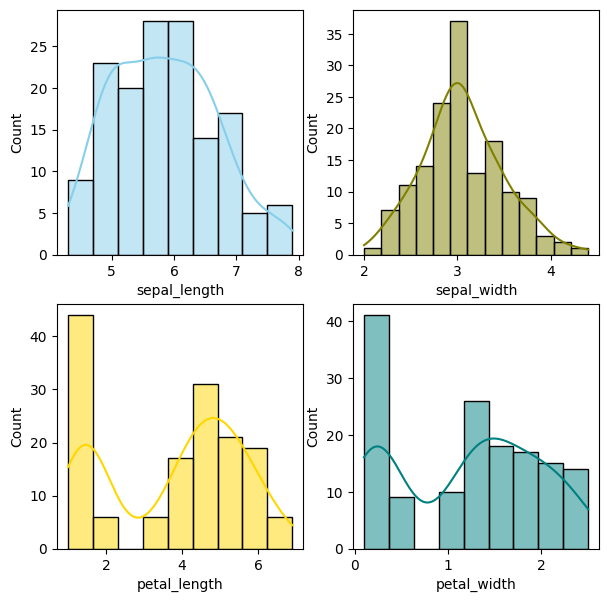

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data=iris_df, x="sepal_length", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=iris_df, x="sepal_width", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=iris_df, x="petal_length", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=iris_df, x="petal_width", kde=True, color="teal", ax=axs[1, 1])

plt.show()  

But here to simplify the problem, we assume that all features are belongs to normal distribution.

$$ f(x|C) = \frac{1}{\sigma_{C}\sqrt{2\pi}}\text{exp}(-{\frac{1}{2}}{\frac{(x-\mu_{c})^2}{\sigma^2}})$$

In [6]:
import math
def gaussian_distribution(X: np.array, mean: np.array, var: np.array) -> np.array:
    """get likelihood based on gaussian distribution
    Args:
        X (np.array): data
        mean (np.array): mean of each feature
        var (np.array): variance of each feature
    Returns:
        likelihood of each feature for each data point"""
    return 1 / np.sqrt(var * 2 * math.pi) * np.exp(-0.5 * (X - mean) ** 2 / var)

With prior probability and likelihood based on gaussian distribution, we can try to calculate posterior probability. The class with highest posterior likelihood is predicted class.

In [7]:
y_pred = []
for x in X:
    posteriors = []

    for c in range(n_classes):
        likelihood = np.sum(gaussian_distribution(x, mean_cf[c], variance_cf[c]))
        prior = prior_c[c]
        posterior = likelihood * prior
        posteriors.append(posterior)

    y_pred.append(np.argmax(posteriors))
    #print('The class of this data point is:', iris['target_names'][y_pred[-1]])

Let compare the actaul class and the predicted class by Naive Bayes.

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

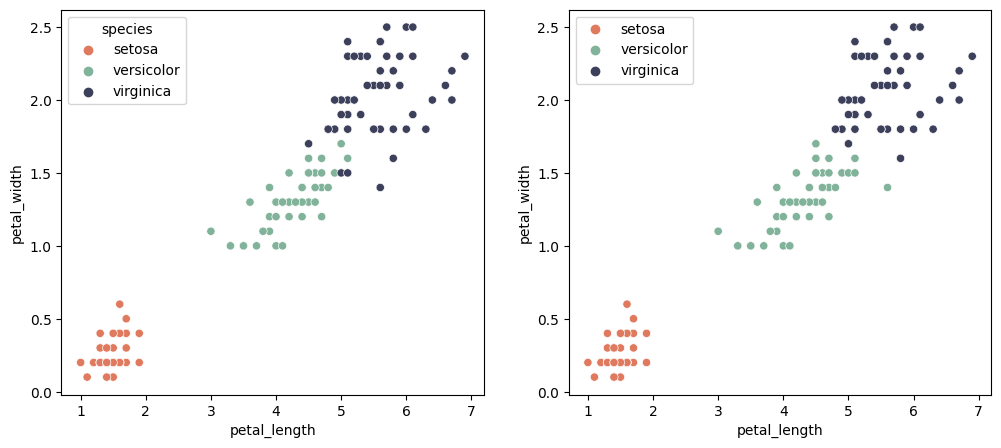

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colormaps = np.array(['#e07a5f','#3d405b','#81b29a'])
sns.scatterplot(
    x='petal_length', 
    y='petal_width',
    hue='species',
    data=iris_df,
    palette=dict(setosa="#e07a5f", virginica="#3d405b", versicolor="#81b29a"),
    ax=axs[0]
    )

sns.scatterplot(
    x=iris_df['petal_length'], 
    y=iris_df['petal_width'],
    hue=iris['target_names'][y_pred],
    palette=dict(setosa="#e07a5f", virginica="#3d405b", versicolor="#81b29a"),
    ax=axs[1]
    )

From above scatter plot, seems most data is correctly classified, let's check the confusion matrix and accuracy.

Accuracy: 95 %


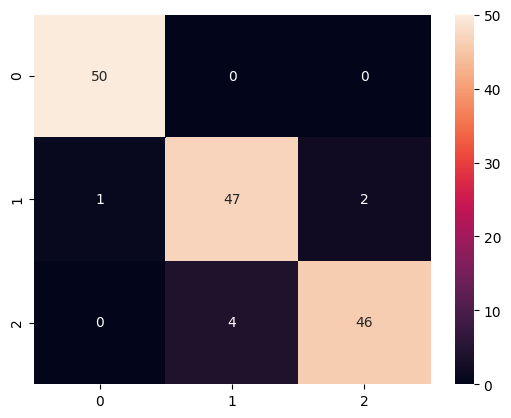

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list(iris_df['species']), [iris['target_names'][x] for x in y_pred], labels=iris['target_names'])

sns.heatmap(cm, annot=True, annot_kws={"size": 10})

acc = np.sum(y==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

Here we get a high accuracy, but this is as expected because we use the same dataset for training and testing. Let's try to split the data into training and testing dataset and use training to get classifier and predict testing data.

In [10]:
from sklearn.model_selection import train_test_split

X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

n_samples, n_features = X_train.shape
n_classes = len(np.unique(y))

mean_cf = np.zeros((n_classes, n_features))
variance_cf = np.zeros((n_classes, n_features))
prior_c = np.zeros(n_classes)

for c in range(n_classes):
    X_c = X_train[y_train==c]

    mean_cf[c] = X_c.mean(axis=0)
    variance_cf[c] = X_c.var(axis=0)
    prior_c[c] = X_c.shape[0] / n_samples

y_pred = []
for x in X_test:
    posteriors = []

    for c in range(n_classes):
        likelihood = np.sum(gaussian_distribution(x, mean_cf[c], variance_cf[c]))
        prior = prior_c[c]
        posterior = likelihood * prior
        posteriors.append(posterior)

    y_pred.append(np.argmax(posteriors))
    #print('The class of this data point is:', iris['target_names'][y_pred[-1]])

Accuracy: 93 %


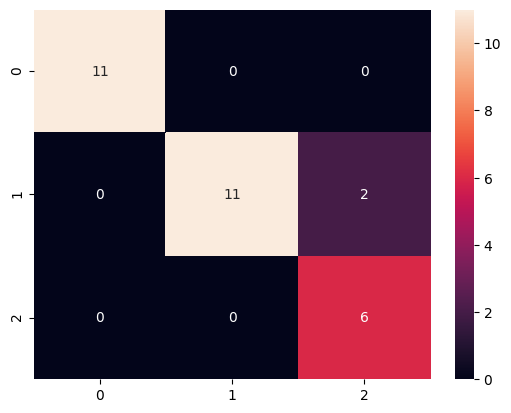

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 10})


acc = np.sum(y_test==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

In [12]:
def NB():
    def __init__(self):
        pass

    def gaussian_distribution(self, X: np.array, mean: np.array, var: np.array) -> np.array:
        """get likelihood based on gaussian distribution
        Args:
            X (np.array): data
            mean (np.array): mean of each feature
            var (np.array): variance of each feature
        Returns:
            likelihood of each feature for each data point"""
        return 1 / np.sqrt(var * 2 * math.pi) * np.exp(-0.5 * (X - mean) ** 2 / var)
    
    def fit(self, X: np.array, y: np.array) -> None:
        """Train Naive Bayes model
        Args:
            X (np.array): training data
            y (np.array): training labels
        """
        n_samples, n_features = X.shape
        n_classes = y.nunique()

        mean_cf = np.zeros((n_classes, n_features))
        variance_cf = np.zeros((n_classes, n_features))
        prior_c = np.zeros(n_classes)

        for c in range(n_classes):
            X_c = X[y==c]

            mean_cf[c] = X_c.mean(axis=0)
            variance_cf[c] = X_c.var(axis=0)
            prior_c[c] = X_c.shape[0] / n_samples


    def predict(self, X: np.array) -> np.array:
        """Predict the testing data labels
        Args:
            X (np.array): testing data
        Returns:
            y_pred (np.array): predicted labels"""
        y_pred = []
        for x in X:
            posteriors = []

            for c in range(n_classes):
                likelihood = np.sum(gaussian_distribution(x, mean_cf[c], variance_cf[c]))
                prior = prior_c[c]
                posterior = likelihood * prior
                posteriors.append(posterior)

            y_pred.append(np.argmax(posteriors))
        
        return y_pred

#### **Reference**
https://medium.com/data-science/implementing-naive-bayes-from-scratch-df5572e042ac  
